In [ ]:
from semantic_text_splitter import TextSplitter

with open("alice.txt", "r") as file:
    contents = file.read()

splitter = TextSplitter((20,120)) # referring to chars here

chunks = splitter.chunks(contents)
chunks.__len__()

2905

In [2]:
import pandas as pd 

df = pd.DataFrame(chunks,columns=["text"])
df

,text
0,Alice’s Adventures in Wonderland
1,by Lewis Carroll\nTHE MILLENNIUM FULCRUM EDITI...
2,Contents\nCHAPTER I.\tDown the Rabbit-Hole
3,CHAPTER II.\tThe Pool of Tears
4,CHAPTER III.\tA Caucus-Race and a Long Tale
...,...
2900,perhaps even with the
2901,dream of Wonderland of
2902,long ago: and how she
2903,would feel with all their


In [3]:
from FlagEmbedding import BGEM3FlagModel
model = BGEM3FlagModel('BAAI/bge-m3', use_fp16=True)

# assuming gdf is a (geo)pandas dataframe with texts to inference

# Step 1: Get the list of texts to encode
df_list = df["text"].to_list()

# Step 2: Deduplicate the list of texts and keep track of the original indices
unique_texts = list(set(df_list))

# Step 3: Perform inference only on the unique texts
unique_embeddings = model.encode(unique_texts, batch_size=12, max_length=2048)['dense_vecs'] # e.g. with bge-m3

# Step 4: Create a mapping from unique texts to embeddings
text_to_embedding = dict(zip(unique_texts, unique_embeddings))

# Step 5: Rebuild the embeddings in the original order using the mapping
embeddings = [text_to_embedding[text] for text in df_list]

df["embeddings"] = list(embeddings)
df

Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

Inference Embeddings: 100%|██████████| 241/241 [00:14<00:00, 16.52it/s]


,text,embeddings
0,Alice’s Adventures in Wonderland,"[-0.04434, 0.02324, -0.05182, 0.04477, 0.00394..."
1,by Lewis Carroll\nTHE MILLENNIUM FULCRUM EDITI...,"[-0.03918, 0.018, 0.00033, 0.0056, -0.04694, 0..."
2,Contents\nCHAPTER I.\tDown the Rabbit-Hole,"[-0.001478, 0.02249, -0.03485, 0.06555, -0.021..."
3,CHAPTER II.\tThe Pool of Tears,"[0.01342, 0.00737, -0.041, 0.03528, -0.0139, -..."
4,CHAPTER III.\tA Caucus-Race and a Long Tale,"[-0.004986, -0.013756, -0.03683, 0.03119, -0.0..."
...,...,...
2900,perhaps even with the,"[-0.02385, 0.05203, -0.0436, 0.02002, -0.0369,..."
2901,dream of Wonderland of,"[-0.009674, 0.01732, -0.02101, -0.05084, -0.03..."
2902,long ago: and how she,"[0.03262, 0.039, -0.06125, 0.036, -0.0279, -0...."
2903,would feel with all their,"[0.00603, 0.00788, -0.03622, 0.01029, -0.02747..."


In [4]:
import numpy as np
from sklearn.random_projection import GaussianRandomProjection
import geopandas as gpd

def reduce_to_2d(vector, random_state=42):
    """
    Reduces a high-dimensional vector to 2D coordinates using Gaussian Random Projection.
    
    Args:
        vector: numpy array or list - Input vector to reduce
        random_state: int - Random seed for reproducibility
    
    Returns:
        tuple (x, y) - 2D coordinates of the reduced vector
    """
    # Reshape vector to 2D array as required by sklearn
    vector = np.array(vector).reshape(1, -1)
    
    # Initialize projection
    rp = GaussianRandomProjection(n_components=2, random_state=random_state)
    
    # Fit and transform in one step
    reduced = rp.fit_transform(vector)
    
    # Return x, y coordinates
    return reduced[0, 0], reduced[0, 1]

reduce_to_2d([0,1,2,3,4,9,5])

(7.480072735693709, -7.089641506373143)

In [5]:
df["X_Y"] = df["embeddings"].apply(reduce_to_2d)
df["X"] = df["X_Y"].apply(lambda x: x[0])
df["Y"] = df["X_Y"].apply(lambda x: x[1])
del df["X_Y"]

In [6]:
gdf = gpd.GeoDataFrame(
        df, 
        geometry=gpd.points_from_xy(df["X"], df["Y"]),
        crs="EPSG:4326"
    )
gdf

,text,embeddings,X,Y,geometry
0,Alice’s Adventures in Wonderland,"[-0.04434, 0.02324, -0.05182, 0.04477, 0.00394...",-1.071105,-0.151973,POINT (-1.0711 -0.15197)
1,by Lewis Carroll\nTHE MILLENNIUM FULCRUM EDITI...,"[-0.03918, 0.018, 0.00033, 0.0056, -0.04694, 0...",-0.275083,-0.557158,POINT (-0.27508 -0.55716)
2,Contents\nCHAPTER I.\tDown the Rabbit-Hole,"[-0.001478, 0.02249, -0.03485, 0.06555, -0.021...",0.016399,-0.350500,POINT (0.0164 -0.3505)
3,CHAPTER II.\tThe Pool of Tears,"[0.01342, 0.00737, -0.041, 0.03528, -0.0139, -...",-0.370321,0.586470,POINT (-0.37032 0.58647)
4,CHAPTER III.\tA Caucus-Race and a Long Tale,"[-0.004986, -0.013756, -0.03683, 0.03119, -0.0...",-0.605694,-0.822739,POINT (-0.60569 -0.82274)
...,...,...,...,...,...
2900,perhaps even with the,"[-0.02385, 0.05203, -0.0436, 0.02002, -0.0369,...",-0.636972,1.157811,POINT (-0.63697 1.15781)
2901,dream of Wonderland of,"[-0.009674, 0.01732, -0.02101, -0.05084, -0.03...",-0.827385,-0.013816,POINT (-0.82739 -0.01382)
2902,long ago: and how she,"[0.03262, 0.039, -0.06125, 0.036, -0.0279, -0....",-0.116355,0.106359,POINT (-0.11635 0.10636)
2903,would feel with all their,"[0.00603, 0.00788, -0.03622, 0.01029, -0.02747...",-0.400154,0.870731,POINT (-0.40015 0.87073)


In [ ]:
gdf.to_parquet("alice.parquet") # just a copy 

gdf["embeddings"] = gdf["embeddings"].apply(lambda x: ",".join(map(str, x))) # workaround, see reading_data.ipynb file
gdf.to_file("alice.fgb",driver="flatgeobuf")

<Axes: >

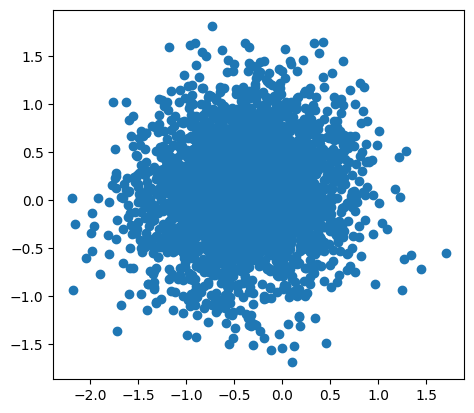

In [9]:
gdf.plot()
